In [2]:
# default
import io
import pickle
import pandas as pd
import numpy as np
import re
import glob
import itertools

# dataset
from sklearn.datasets import load_iris, make_moons, load_breast_cancer
from keras.datasets import imdb, cifar10

# preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.utils import np_utils, multi_gpu_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from sklearn.manifold import TSNE

# graphics
%matplotlib inline
import pydot
from IPython.core.display import Image
from PIL import Image
from sklearn.tree import export_graphviz
import seaborn as sns
import mglearn
import matplotlib as mpl
import matplotlib.pyplot as plt

# general
import tensorflow as tf
from keras import layers
import keras.backend as K
from keras.layers import Input, Dense, Activation, Flatten, Dropout, BatchNormalization, Embedding, Reshape
from keras.layers.convolutional import Conv2D, Convolution2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from keras.layers.convolutional import Conv3D, Convolution3D, MaxPooling3D, AveragePooling3D, UpSampling3D
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D
from keras.layers import LSTM, TimeDistributed, CuDNNLSTM
from keras.models import Model, load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint

# classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from keras.metrics import top_k_categorical_accuracy

# customize
def plot_decision_regions(X, y, model, title):
    resolution = 0.01
    markers = ('s', '^', 'o')
    colors = ('red', 'blue', 'lightgreen')
    cmap = mpl.colors.ListedColormap(colors)

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = model.predict(np.array([xx1.ravel(), xx2.ravel()]).T).reshape(xx1.shape)
    resolution = 0.01
    markers = ('s', '^', 'o')
    colors = ('red', 'blue', 'lightgreen')
    cmap = mpl.colors.ListedColormap(colors)

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = model.predict(np.array([xx1.ravel(), xx2.ravel()]).T).reshape(xx1.shape)
    plt.contour(xx1, xx2, Z, cmap=mpl.colors.ListedColormap(['k']))
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8,
        c=[cmap(idx)], marker=markers[idx], s=80, label=cl)
    plt.xlabel(iris.feature_names[2])
    plt.ylabel(iris.feature_names[3])
    plt.legend(loc='upper left')
    plt.title(title)
    return Z

def plot_confusion_matrix(model, X_target, Y_target, label_info):
    Y_pred = model.predict(X_target)
    cnf_matrix = confusion_matrix(np.argmax(Y_pred, axis=1), np.argmax(Y_target, axis=1))
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    marks = np.arange(len(label_info))
    plt.xticks(marks, label_info, rotation=45)
    plt.xticks(marks, label_info, rotation=45)
    thresh = cnf_matrix.max()/2.
    for i in range(cnf_matrix.shape[0]):
        for j in range(cnf_matrix.shape[1]):
            plt.text(j, i, cnf_matrix[i, j], horizontalalignment='center', color='white' if cnf_matrix[i,j]>thresh else 'black')
    plt.ylabel('Actual'), plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()
    
# Preprocessing Method
def unpickle(file):
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data
def load_cifar_10_data(data_dir, negatives=False):
    meta_data_dict = unpickle(data_dir+'/batches.meta')
    cifar_label_names = meta_data_dict[b'label_names']
    cifar_label_names = np.array(cifar_label_names)
    cifar_train_data = None
    cifar_train_filenames = []
    cifar_train_labels = []
    for i in range(1, 6):
        cifar_train_data_dict = unpickle(data_dir+'/data_batch_{}'.format(i))
        if i==1:
            cifar_train_data = cifar_train_data_dict[b'data']
        else:
            cifar_train_data = np.vstack((cifar_train_data, cifar_train_data_dict[b'data']))
        cifar_train_filenames += cifar_train_data_dict[b'filenames']
        cifar_train_labels += cifar_train_data_dict[b'labels']
    cifar_train_data = cifar_train_data.reshape((len(cifar_train_data), 3, 32, 32))
    if negatives:
        cifar_train_data = cifar_train_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_train_data = np.rollaxis(cifar_train_data, 1, 4)
    cifar_train_filenames = np.array(cifar_train_filenames)
    cifar_train_labels = np.array(cifar_train_labels)
    cifar_test_data_dict = unpickle(data_dir+'/test_batch')
    cifar_test_data = cifar_test_data_dict[b'data']
    cifar_test_filenames = cifar_test_data_dict[b'filenames']
    cifar_test_labels = cifar_test_data_dict[b'labels']
    cifar_test_data = cifar_test_data.reshape((len(cifar_test_data), 3, 32, 32))
    if negatives:
        cifar_test_data = cifar_test_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_test_data = np.rollaxis(cifar_test_data, 1, 4)
    cifar_test_filenames = np.array(cifar_test_filenames)
    cifar_test_labels = np.array(cifar_test_labels)
    return cifar_train_data, cifar_train_filenames, cifar_train_labels, cifar_test_data, cifar_test_filenames, cifar_test_labels, cifar_label_names

# Handcrafted Function Def.
def wrapped_confusion_matrix(modelInput, feature, label, class_list=["first", "second"], normalize=False, fig_size=(5,5)):
    pred = modelInput.predict(feature)
    cnf_matrix = confusion_matrix(np.argmax(label, axis=1), np.argmax(pred, axis=1))
    np.set_printoptions(precision=2)
    plt.figure(figsize=fig_size) 
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.xticks(np.arange(len(class_list)), class_list, rotation=45)
    plt.yticks(np.arange(len(class_list)), class_list)
    if(normalize):
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    thresh = cnf_matrix.max() / 2.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment='center',
                 color='white' if cnf_matrix[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
def plot_history(model_input, mode='loss', val_mode=True, title='Entropy'):
    history = model_input.history
    if(val_mode):
        plt.plot(history.history[mode])
        plt.plot(history.history['val_'+mode])
        plt.title(title)
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()
    else:
        plt.plot(history.history[mode])
        plt.title(title)
        plt.legend(['train'], loc='upper right')
        plt.show()


Train set:  (3000, 64, 64, 3) (3000, 3) Test set:  (1000, 64, 64, 3) (1000, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 16)        1040      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 4096)              0         
______________________________________________________________

None

Train on 3000 samples, validate on 1000 samples
Epoch 1/10
 - 13s - loss: 0.2190 - acc: 0.4440 - val_loss: 0.2136 - val_acc: 0.5240
Epoch 2/10
 - 12s - loss: 0.2120 - acc: 0.4940 - val_loss: 0.2078 - val_acc: 0.5150
Epoch 3/10
 - 12s - loss: 0.2073 - acc: 0.5030 - val_loss: 0.2037 - val_acc: 0.5150
Epoch 4/10
 - 12s - loss: 0.2040 - acc: 0.5063 - val_loss: 0.2008 - val_acc: 0.5160
Epoch 5/10
 - 12s - loss: 0.2016 - acc: 0.5057 - val_loss: 0.1987 - val_acc: 0.5150
Epoch 6/10
 - 12s - loss: 0.2000 - acc: 0.5063 - val_loss: 0.1972 - val_acc: 0.5170
Epoch 7/10
 - 13s - loss: 0.1987 - acc: 0.5063 - val_loss: 0.1961 - val_acc: 0.5150
Epoch 8/10
 - 13s - loss: 0.1978 - acc: 0.5047 - val_loss: 0.1953 - val_acc: 0.5150
Epoch 9/10
 - 12s - loss: 0.1971 - acc: 0.5047 - val_loss: 0.1946 - val_acc: 0.5150
Epoch 10/10
 - 12s - loss: 0.1966 - acc: 0.5040 - val_loss: 0.1941 - val_acc: 0.5150


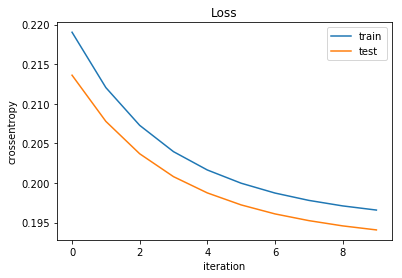

In [26]:
# data loading and preprocessing
X_train, X_test = np.load('./dataset/X_train.npy'), np.load('./dataset/X_test.npy') 
Y_train, Y_test = np.load('./dataset/Y_train.npy'), np.load('./dataset/Y_test.npy') 
print('\nTrain set: ', X_train.shape, Y_train.shape, 'Test set: ', X_test.shape, Y_test.shape)

# X_train, X_test = X_train/255., X_test/255.
# print('\nTrain set: ', X_train.shape, Y_train.shape, 'Test set: ', X_test.shape, Y_test.shape)

# modeling
X_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
X_hidden = Conv2D(16, kernel_size=(2,2), padding='same', activation='relu')(X_input)
X_hidden = MaxPooling2D((2,2))(X_hidden)
X_hidden = Conv2D(16, kernel_size=(2,2), padding='same', activation='relu')(X_hidden)
X_hidden = MaxPooling2D((2,2))(X_hidden)
X_hidden = Flatten()(X_hidden)
X_hidden = Dense(512, activation='relu')(X_hidden)
Y_output = Dense(Y_train.shape[1], activation='softmax')(X_hidden)
model_cnn = Model(X_input, Y_output)
display(model_cnn.summary())
## optimization step
## loss = ['categorical_crossentropy', 'mean_squared_error', 'kullback_leibler_divergence']
## optimizer = ['sgd', 'adadelta', 'adam']
model_cnn.compile(loss='mean_squared_error', optimizer='sgd', metrics=['acc'])
model_history = model_cnn.fit(X_train, Y_train, 
                              validation_data=(X_test, Y_test), 
                              epochs=10, batch_size=512, verbose=2, shuffle=True)

# evaluation
## loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Loss')
plt.xlabel('iteration'), plt.ylabel('crossentropy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
## accuracy
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('iteration'), plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
## confusion matrix
plot_confusion_matrix(model_cnn, X_test, Y_test, range(0,3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 16)        1040      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 512)               2097664   
__________

None

Train on 3000 samples, validate on 1000 samples
Epoch 1/10
 - 14s - loss: 0.2302 - acc: 0.4400 - val_loss: 0.2058 - val_acc: 0.3990
Epoch 2/10
 - 12s - loss: 0.2041 - acc: 0.4790 - val_loss: 0.1939 - val_acc: 0.5200
Epoch 3/10
 - 12s - loss: 0.1959 - acc: 0.5330 - val_loss: 0.1903 - val_acc: 0.5520
Epoch 4/10
 - 12s - loss: 0.1915 - acc: 0.5543 - val_loss: 0.1878 - val_acc: 0.5530
Epoch 5/10
 - 12s - loss: 0.1835 - acc: 0.5973 - val_loss: 0.1793 - val_acc: 0.6090
Epoch 6/10
 - 12s - loss: 0.1766 - acc: 0.6260 - val_loss: 0.1751 - val_acc: 0.6020
Epoch 7/10
 - 12s - loss: 0.1698 - acc: 0.6350 - val_loss: 0.1685 - val_acc: 0.6150
Epoch 8/10
 - 12s - loss: 0.1632 - acc: 0.6457 - val_loss: 0.1617 - val_acc: 0.6470
Epoch 9/10
 - 13s - loss: 0.1584 - acc: 0.6673 - val_loss: 0.1586 - val_acc: 0.6540
Epoch 10/10
 - 12s - loss: 0.1532 - acc: 0.6747 - val_loss: 0.1558 - val_acc: 0.6560


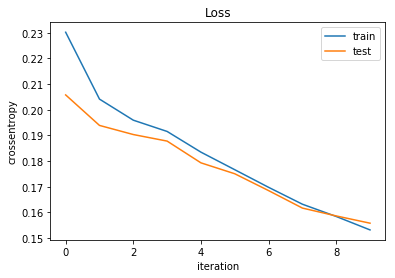

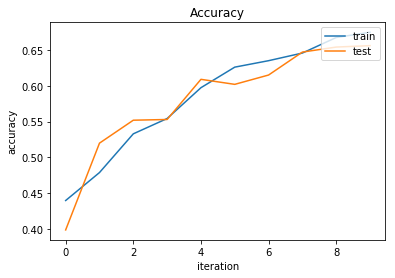

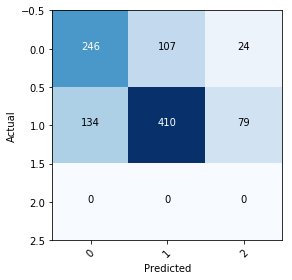

In [28]:
# fast optimizer: adam

# modeling
X_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
X_hidden = Conv2D(16, kernel_size=(2,2), padding='same', activation='relu')(X_input)
X_hidden = MaxPooling2D((2,2))(X_hidden)
X_hidden = Conv2D(16, kernel_size=(2,2), padding='same', activation='relu')(X_hidden)
X_hidden = MaxPooling2D((2,2))(X_hidden)
X_hidden = Flatten()(X_hidden)
X_hidden = Dense(512, activation='relu')(X_hidden)
Y_output = Dense(Y_train.shape[1], activation='softmax')(X_hidden)
model_cnn = Model(X_input, Y_output)
display(model_cnn.summary())
## optimization step
## loss = ['categorical_crossentropy', 'mean_squared_error', 'kullback_leibler_divergence']
## optimizer = ['sgd', 'adadelta', 'adam']
model_cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['acc'])
model_history = model_cnn.fit(X_train, Y_train, 
                              validation_data=(X_test, Y_test), 
                              epochs=10, batch_size=512, verbose=2, shuffle=True)

# evaluation
## loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Loss')
plt.xlabel('iteration'), plt.ylabel('crossentropy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
## accuracy
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('iteration'), plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
## confusion matrix
plot_confusion_matrix(model_cnn, X_test, Y_test, range(0,3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 32, 32, 16)        1040      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 512)               2097664   
__________

None

Train on 3000 samples, validate on 1000 samples
Epoch 1/10
 - 14s - loss: 0.1994 - acc: 0.5043 - val_loss: 0.1956 - val_acc: 0.4830
Epoch 2/10
 - 12s - loss: 0.1951 - acc: 0.4963 - val_loss: 0.1931 - val_acc: 0.5180
Epoch 3/10
 - 12s - loss: 0.1948 - acc: 0.5037 - val_loss: 0.1899 - val_acc: 0.5170
Epoch 4/10
 - 12s - loss: 0.1958 - acc: 0.4890 - val_loss: 0.1907 - val_acc: 0.5170
Epoch 5/10
 - 12s - loss: 0.1919 - acc: 0.5303 - val_loss: 0.1901 - val_acc: 0.5170
Epoch 6/10
 - 12s - loss: 0.1916 - acc: 0.5240 - val_loss: 0.1937 - val_acc: 0.4920
Epoch 7/10
 - 12s - loss: 0.1910 - acc: 0.5187 - val_loss: 0.1878 - val_acc: 0.5430
Epoch 8/10
 - 12s - loss: 0.1905 - acc: 0.5377 - val_loss: 0.1901 - val_acc: 0.5170
Epoch 9/10
 - 12s - loss: 0.1898 - acc: 0.5403 - val_loss: 0.1896 - val_acc: 0.5180
Epoch 10/10
 - 12s - loss: 0.1903 - acc: 0.5313 - val_loss: 0.1859 - val_acc: 0.5350


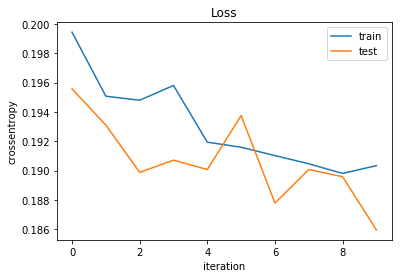

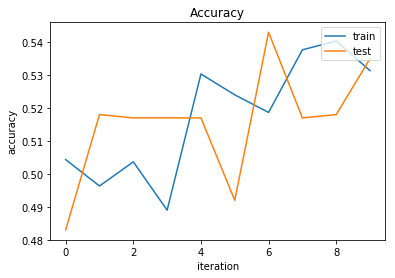

In [32]:
# customization of optimizer
my_sgd = SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False)

# modeling
X_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
X_hidden = Conv2D(16, kernel_size=(2,2), padding='same', activation='relu')(X_input)
X_hidden = MaxPooling2D((2,2))(X_hidden)
X_hidden = Conv2D(16, kernel_size=(2,2), padding='same', activation='relu')(X_hidden)
X_hidden = MaxPooling2D((2,2))(X_hidden)
X_hidden = Flatten()(X_hidden)
X_hidden = Dense(512, activation='relu')(X_hidden)
Y_output = Dense(Y_train.shape[1], activation='softmax')(X_hidden)
model_cnn = Model(X_input, Y_output)
display(model_cnn.summary())
## optimization step
## loss = ['categorical_crossentropy', 'mean_squared_error', 'kullback_leibler_divergence']
## optimizer = ['sgd', 'adadelta', 'adam']
model_cnn.compile(loss='mean_squared_error', optimizer=my_sgd, metrics=['acc'])
model_history = model_cnn.fit(X_train, Y_train, 
                              validation_data=(X_test, Y_test), 
                              epochs=10, batch_size=512, verbose=2, shuffle=True)

# evaluation
## loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Loss')
plt.xlabel('iteration'), plt.ylabel('crossentropy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
## accuracy
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('iteration'), plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
## confusion matrix
plot_confusion_matrix(model_cnn, X_test, Y_test, range(0,3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 32, 32, 16)        1040      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 512)               2097664   
__________

None

Train on 3000 samples, validate on 1000 samples
Epoch 1/50
 - 14s - loss: 0.2334 - acc: 0.4653 - val_loss: 0.1963 - val_acc: 0.4550
Epoch 2/50
 - 12s - loss: 0.1941 - acc: 0.5043 - val_loss: 0.1901 - val_acc: 0.5150
Epoch 3/50
 - 13s - loss: 0.1926 - acc: 0.5170 - val_loss: 0.1938 - val_acc: 0.4650
Epoch 4/50
 - 13s - loss: 0.1926 - acc: 0.5103 - val_loss: 0.1928 - val_acc: 0.4700
Epoch 5/50
 - 12s - loss: 0.1922 - acc: 0.5130 - val_loss: 0.1905 - val_acc: 0.5090


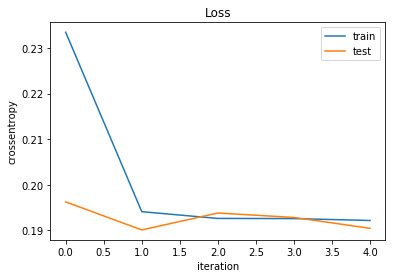

In [33]:
# optimizer: adadelta
# fit: EarlyStopping

# modeling
X_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
X_hidden = Conv2D(16, kernel_size=(2,2), padding='same', activation='relu')(X_input)
X_hidden = MaxPooling2D((2,2))(X_hidden)
X_hidden = Conv2D(16, kernel_size=(2,2), padding='same', activation='relu')(X_hidden)
X_hidden = MaxPooling2D((2,2))(X_hidden)
X_hidden = Flatten()(X_hidden)
X_hidden = Dense(512, activation='relu')(X_hidden)
Y_output = Dense(Y_train.shape[1], activation='softmax')(X_hidden)
model_cnn = Model(X_input, Y_output)
display(model_cnn.summary())
## optimization step
## loss = ['categorical_crossentropy', 'mean_squared_error', 'kullback_leibler_divergence']
## optimizer = ['sgd', 'adadelta', 'adam']
model_cnn.compile(loss='mean_squared_error', optimizer='adadelta', metrics=['acc'])
es = EarlyStopping(mode='auto', monitor='val_loss', patience=3)
model_history = model_cnn.fit(X_train, Y_train, 
                              validation_data=(X_test, Y_test), 
                              epochs=50, batch_size=512, verbose=2, shuffle=True,
                              callbacks=[es])

# evaluation
## loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Loss')
plt.xlabel('iteration'), plt.ylabel('crossentropy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
## accuracy
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('iteration'), plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
## confusion matrix
plot_confusion_matrix(model_cnn, X_test, Y_test, range(0,3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 64, 64, 16)        208       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 32, 32, 16)        1040      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 16)        64        
__________

None

Train on 3000 samples, validate on 1000 samples
Epoch 1/10
 - 16s - loss: 0.3254 - acc: 0.4707 - val_loss: 0.3195 - val_acc: 0.5060
Epoch 2/10
 - 14s - loss: 0.3078 - acc: 0.5153 - val_loss: 0.3124 - val_acc: 0.5200
Epoch 3/10
 - 14s - loss: 0.2894 - acc: 0.5370 - val_loss: 0.2761 - val_acc: 0.5430
Epoch 4/10
 - 14s - loss: 0.2623 - acc: 0.5580 - val_loss: 0.2864 - val_acc: 0.5390
Epoch 5/10
 - 14s - loss: 0.2601 - acc: 0.5663 - val_loss: 0.2621 - val_acc: 0.5330
Epoch 6/10
 - 16s - loss: 0.2550 - acc: 0.5710 - val_loss: 0.2087 - val_acc: 0.6150
Epoch 7/10
 - 14s - loss: 0.2093 - acc: 0.6267 - val_loss: 0.2434 - val_acc: 0.5510
Epoch 8/10
 - 14s - loss: 0.2061 - acc: 0.6210 - val_loss: 0.1843 - val_acc: 0.6560
Epoch 9/10
 - 14s - loss: 0.1980 - acc: 0.6287 - val_loss: 0.2203 - val_acc: 0.6090
Epoch 10/10
 - 15s - loss: 0.2043 - acc: 0.6260 - val_loss: 0.1680 - val_acc: 0.6720


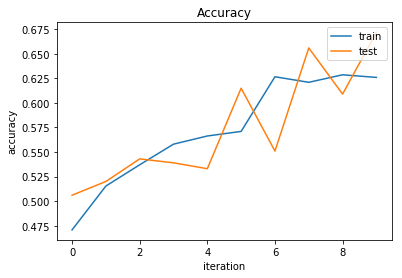

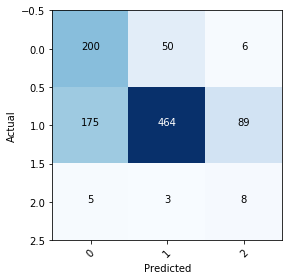

In [34]:
# dropout and batchnormalization

# modeling
X_input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
X_hidden = Conv2D(16, kernel_size=(2,2), padding='same', activation='relu')(X_input)
X_hidden = MaxPooling2D((2,2))(X_hidden)
X_hidden = BatchNormalization()(X_hidden)
X_hidden = Conv2D(16, kernel_size=(2,2), padding='same', activation='relu')(X_hidden)
X_hidden = MaxPooling2D((2,2))(X_hidden)
X_hidden = BatchNormalization()(X_hidden)
X_hidden = Dropout(0.5)(X_hidden)
X_hidden = Flatten()(X_hidden)
X_hidden = Dense(512, activation='relu')(X_hidden)
Y_output = Dense(Y_train.shape[1], activation='softmax')(X_hidden)
model_cnn = Model(X_input, Y_output)
display(model_cnn.summary())
## optimization step
## loss = ['categorical_crossentropy', 'mean_squared_error', 'kullback_leibler_divergence']
## optimizer = ['sgd', 'adadelta', 'adam']
model_cnn.compile(loss='mean_squared_error', optimizer='adadelta', metrics=['acc'])
es = EarlyStopping(mode='auto', monitor='val_loss', patience=3)
model_history = model_cnn.fit(X_train, Y_train, 
                              validation_data=(X_test, Y_test), 
                              epochs=10, batch_size=512, verbose=2, shuffle=True,
                              callbacks=[es])

# evaluation
## loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Loss')
plt.xlabel('iteration'), plt.ylabel('crossentropy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
## accuracy
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Accuracy')
plt.xlabel('iteration'), plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
## confusion matrix
plot_confusion_matrix(model_cnn, X_test, Y_test, range(0,3))